# Introduction to Knowledge Graph Embeddings

Run the provided `get_data_and_setup.sh` script to download the data and set up the environment. This script will download the data and install the required libraries.

```bash
./get_data_and_setup.sh
```

Now let's read the triples (splitted in training, validation, and test set) from the UMLS dataset, and visualise part of the training set.

In [1]:
# @title
from os.path import splitext
from typing import List, Tuple, Set, Dict, Optional, Iterable, Pattern


def read_triples(path: str) -> List[Tuple[str, str, str]]:
    triples = []
    with open(path, 'rt') as f:
        for line in f:
            s, p, o = line.split('\t')
            triples += [(s.strip(), p.strip(), o.strip())]
    return triples


#Pay attention that we can change umls to wordnet or freebase
train_triples_lst = read_triples('data/umls/train.txt')
valid_triples_lst = read_triples('data/umls/valid.txt')
test_triples_lst = read_triples('data/umls/test.txt')

import pandas as pd

train_df = pd.DataFrame(train_triples_lst, columns=['Subject', 'Predicate', 'Object'])
train_df

,Subject,Predicate,Object
0,acquired_abnormality,location_of,experimental_model_of_disease
1,anatomical_abnormality,manifestation_of,physiologic_function
2,alga,isa,entity
3,mental_or_behavioral_dysfunction,affects,experimental_model_of_disease
4,health_care_activity,associated_with,anatomical_abnormality
...,...,...,...
5211,congenital_abnormality,part_of,human
5212,diagnostic_procedure,precedes,therapeutic_or_preventive_procedure
5213,cell_component,part_of,alga
5214,mental_process,produces,age_group


Let's create the set $E$ entities and the set $R$ of relation types, respectively denoted as `entity_set` and `predicate_set` in the following code.

Then, we associate an unique integer between $0$ and $|E| - 1$ to each entity $e \in E$, and an unique integer between $0$ and $|R| - 1$ to each relation type $p \in R$ -- these are saved in the `entity_to_idx` and `predicate_to_idx` dictionaries in the following code.

In [22]:
# @title
all_triples_lst: List[Tuple[str, str, str]] = train_triples_lst + valid_triples_lst + test_triples_lst

# Set E of all entities
entity_set: Set[str] = {s for s, _, _ in all_triples_lst} | {o for _, _, o in all_triples_lst}
# Set R of all relation types
predicate_set: Set[str] = {p for _, p, _ in all_triples_lst}

# Map every entity and predicate with an unique index from 0 to |E|
entity_lst: List[str] = sorted(entity_set)
predicate_lst: List[str] = sorted(predicate_set)

# Entity/predicate -> index maps
entity_to_idx: Dict[str, int] = {entity: idx for idx, entity in enumerate(entity_lst)}
predicate_to_idx: Dict[str, int] = {predicate: idx for idx, predicate in enumerate(predicate_lst)}

# Index -> entity/predicate maps
idx_to_entity: Dict[int, str] = {idx: entity for entity, idx in entity_to_idx.items()}
idx_to_predicate: Dict[int, str] = {idx: predicate for predicate, idx in predicate_to_idx.items()}

print("|E| is", len(entity_set), "while |R| is", len(predicate_set))

|E| is 135 while |R| is 46


We now transform the training, validation, and test set in PyTorch matrices with shape $|T| \times 3$, where $T \subseteq E \times R \times E$ denotes the set of triples and the first, second, and third column contain the indices of the subjects, predicates, and objects of the triples, respectively. Given a set of triples $T$, this code produces a matrix $\mathbf{T} \in \mathbb{N}_{+}^{|T| \times 3}$ containing the indices of the entities and relation types in $T$.

Below displays the first rows of the matrix generated from the UMLS training set.

In [23]:
# @title
import numpy as np

import torch
from torch import nn, Tensor


# Convert the training, validation, and test sets to numpy matrices with shape |S| x 3
def triples_to_matrix(triple_lst: List[Tuple[str, str, str]]) -> np.array:
    index_lst = [(entity_to_idx[s], predicate_to_idx[p], entity_to_idx[o]) for s, p, o in triple_lst]
    return np.array(index_lst, dtype=np.int32)


train_np = triples_to_matrix(train_triples_lst)
valid_np = triples_to_matrix(valid_triples_lst)
test_np = triples_to_matrix(test_triples_lst)
all_np = triples_to_matrix(all_triples_lst)

# Now we need to start using PyTorch tensors -- let's first check if we have GPU support
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

# Let's convert the training, validation, and test sets to (PyTorch) tensors
train_t = torch.tensor(train_np, dtype=torch.long, device=device)
valid_t = torch.tensor(valid_np, dtype=torch.long, device=device)
test_t = torch.tensor(test_np, dtype=torch.long, device=device)
all_t = torch.tensor(all_np, dtype=torch.long, device=device)

train_df = pd.DataFrame(train_t.cpu().numpy(), columns=['Subject Indices', 'Predicate Indices', 'Object Indices'])
train_df

,Subject Indices,Predicate Indices,Object Indices
0,0,27,50
1,7,29,110
2,3,25,46
3,86,1,50
4,65,4,7
...,...,...,...
5211,37,34,68
5212,39,37,130
5213,27,34,3
5214,87,40,2


Let's now define the model we will be using. Here it shows DistMult's code, where the scoring function is simply defined as $f(\mathbf{s}, \mathbf{p}, \mathbf{o}) = \langle \mathbf{s}, \mathbf{p}, \mathbf{o} \rangle = \sum_{i} \mathbf{s}_{i} \mathbf{p}_{i} \mathbf{o}_{i}$.

Note that the model has two methods:
- The `score` method receives a batch of triples, and produces a score for each of the triples.
- The `forward` method has three arguments, `s` for subjects, `p` for predicates, and `o` for objects: if one of them is set to `None`, this method efficiently produces a score for all candidate entities or relation types for replacing the missing argument. This will be extremely useful to compute some training objective efficiently.

In [32]:
# Let's create a PyTorch link prediction model -- we will use the DistMult scoring function

class DistMult(nn.Module):
    def __init__(self, nb_entities: int, nb_predicates: int, embedding_size: int):
        super().__init__()
        self.nb_entities = nb_entities
        self.nb_predicates = nb_predicates
        self.embedding_size = embedding_size

        # This is the encoder part of the model, and the emeddings for the entities and relation types
        # represent the parameters θ of the encoder.
        self.entity_embeddings = nn.Embedding(nb_entities, self.embedding_size, sparse=True)
        self.predicate_embeddings = nn.Embedding(nb_predicates, self.embedding_size, sparse=True)

        # Small trick from https://github.com/facebookresearch/kbc/
        self.entity_embeddings.weight.data *= 1e-3
        self.predicate_embeddings.weight.data *= 1e-3

    def score(self, triple: Tensor) -> Tensor:
        # triple is a batch_size x 3 tensor containing a batch of triples, where triple[0], triple[1], and triple[2]
        # correspond to the indices of the subjects, predicates, and objects, respectively.

        # We first look up the embedding of the subjects, predicates, and objects of the input triples ..
        # TODO: Implement the scoring function of DistMult
        s = self.entity_embeddings(triple[:, 0])
        p = self.predicate_embeddings(triple[:, 1])
        o = self.entity_embeddings(triple[:, 2])
        print("s, p, o", s.shape, p.shape, o.shape)
        res = torch.sum(s * p * o, dim=1)
        # [B] Tensor
        return res

    def forward(self, s: Optional[Tensor], p: Optional[Tensor], o: Optional[Tensor]) -> Tensor:
        # s, p, and o are the indices of subjects, predicates, and objects, respecitvely.
        # This function is similar to the previous score() but it requires you not to specify one among the
        # subject, predicate, and object of a batch of triples, and gives you a score for all possible candidates
        assert [s, p, o].count(None) <= 1, "s, p, or o should be None"

        s_emb = self.entity_embeddings(s) if s is not None else self.entity_embeddings.weight
        p_emb = self.predicate_embeddings(p) if p is not None else self.predicate_embeddings.weight
        o_emb = self.entity_embeddings(o) if o is not None else self.entity_embeddings.weight

        # [B] Tensor
        scores = None

        if p is None:
            # If the predicate is not specified, we compute the scores of all the triples obtained by using the
            # predicates in R as predicate values.
            #TODO: Implement the scoring function given the predicate is None
            # scores = torch.einsum('bik,jk,bik->bij', s_emb, p_emb, o_emb)
            scores = (s_emb * o_emb) @ p_emb.t()

        elif s is None:
            # If the subject is not specified, we compute the scores of all the triples obtained by using the
            # entities in E as subject values.
            scores = (p_emb * o_emb) @ s_emb.t()
        elif o is None:
            # If the object is not specified, we compute the scores of all the triples obtained by using the
            # entities in E as object values.
            scores = (s_emb * p_emb) @ o_emb.t()
        else:
            # Subject, predicare, and object values were specified -- we compute the score of the triple.
            scores = self.score(torch.cat([s.view(-1, 1), p.view(-1, 1), o.view(-1, 1)], dim=1))

        assert scores is not None
        return scores

    def factor(self, idx: Tensor, is_entity: bool = True) -> Tensor:
        # This method is used for regularisation -- more on this later.
        embedding_layer = self.entity_embeddings if is_entity is True else self.predicate_embeddings
        emb = embedding_layer(idx)
        return emb

Here we will show TransE's code, where the scoring function is defined as $f(\mathbf{s}, \mathbf{p}, \mathbf{o}) = -\|\mathbf{s} + \mathbf{p} - \mathbf{o}\|_{2}$.

In [46]:
class RESCAL(nn.Module):
    def __init__(self, nb_entities: int, nb_predicates: int, embedding_size: int):
        super().__init__()
        self.nb_entities = nb_entities
        self.nb_predicates = nb_predicates
        self.embedding_size = embedding_size

        # This is the encoder part of the model, and the emeddings for the entities and relation types
        # represent the parameters θ of the encoder.
        self.entity_embeddings = nn.Embedding(nb_entities, self.embedding_size, sparse=True)
        self.predicate_matrices = nn.Embedding(nb_predicates, self.embedding_size * self.embedding_size, sparse=True)

        # Small trick from

        self.entity_embeddings.weight.data *= 1e-3
        self.predicate_matrices.weight.data *= 1e-3

    def score(self, triple: Tensor) -> Tensor:
        s = self.entity_embeddings(triple[:, 0])
        p = self.predicate_matrices(triple[:, 1]).view(-1, self.embedding_size, self.embedding_size)
        o = self.entity_embeddings(triple[:, 2])
        print("s, p, o", s.shape, p.shape, o.shape)
        intermediate = torch.matmul(p, o.unsqueeze(-1))
        res = torch.sum(s * intermediate.squeeze(-1), dim=1)
        # res = torch.sum(s.unsqueeze(1) @ p @ o.unsqueeze(2), dim=(1, 2))
        return res

    def forward(self, s: Optional[Tensor], p: Optional[Tensor], o: Optional[Tensor]) -> Tensor:

        assert [s, p, o].count(None) <= 1, "s, p, or o should be None"

        s_emb = self.entity_embeddings(s) if s is not None else self.entity_embeddings.weight
        p_emb = self.predicate_matrices(p).view(-1, self.embedding_size,
                                                self.embedding_size) if p is not None else self.predicate_matrices.weight.view(
            -1, self.embedding_size, self.embedding_size)
        o_emb = self.entity_embeddings(o) if o is not None else self.entity_embeddings.weight

        scores = None

        if p is None:
            scores = torch.einsum('bi,njk,bk->bn', s_emb, p_emb, o_emb)
        elif s is None:
            scores = torch.einsum('bjk,bk->bj', p_emb, o_emb)
        elif o is None:
            scores = torch.einsum('bi,bik->bk', s_emb, p_emb)
        else:
            scores = self.score(torch.cat([s.view(-1, 1), p.view(-1, 1), o.view(-1, 1)], dim=1))

        assert scores is not None
        return scores

    def factor(self, idx: Tensor, is_entity: bool = True) -> Tensor:
        embedding_layer = self.entity_embeddings if is_entity is True else self.predicate_matrices
        emb = embedding_layer(idx)
        return emb



Here it shows ComplEx's code, where the scoring function is defined as $f(\mathbf{s}, \mathbf{p}, \mathbf{o}) = \text{Re}(\langle \mathbf{s}, \mathbf{p}, \overline{\mathbf{o}} \rangle)$.

Note that the model has two methods:
- The `score` method receives a batch of triples, and produces a score for each of the triples.
- The `forward` method has three arguments, `s` for subjects, `p` for predicates, and `o` for objects: if one of them is set to `None`, this method efficiently produces a score for all candidate entities or relation types for replacing the missing argument. This will be extremely useful to compute some training objective efficiently.

In [58]:
# @title
# Let's create a PyTorch link prediction model -- we will use the ComplEx scoring function

class ComplEx(nn.Module):
    def __init__(self, nb_entities: int, nb_predicates: int, embedding_size: int):
        super().__init__()
        self.nb_entities = nb_entities
        self.nb_predicates = nb_predicates
        self.embedding_size = embedding_size

        # Remeber that ComplEx has complex embeddings -- here we will use
        # x[:embedding_size] as the real part, and x[embedding_size:] as the
        # imaginary part of the representations
        self.entity_embeddings = nn.Embedding(nb_entities, self.embedding_size * 2, sparse=True)
        self.predicate_embeddings = nn.Embedding(nb_predicates, self.embedding_size * 2, sparse=True)

        # Small trick from https://github.com/facebookresearch/kbc/
        self.entity_embeddings.weight.data *= 1e-3
        self.predicate_embeddings.weight.data *= 1e-3

    def score(self, triple: Tensor) -> Tensor:
        # triple is a batch_size x 3 tensor containing a batch of triples, where triple[0], triple[1], and triple[2]
        # correspond to the indices of the subjects, predicates, and objects, respectively.
        s = self.entity_embeddings(triple[:, 0])
        p = self.predicate_embeddings(triple[:, 1])
        o = self.entity_embeddings(triple[:, 2])
        
        s_real, s_img = s[:, :self.embedding_size], s[:, self.embedding_size:]
        p_real, p_img = p[:, :self.embedding_size], p[:, self.embedding_size:]
        o_real, o_img = o[:, :self.embedding_size], o[:, self.embedding_size:]
        
        res = torch.sum((s_real * o_real + s_img * o_img) @ p_real.t() + (s_real * o_img - s_img * o_real) @ p_img.t(), dim=1)
        # res = torch.sum(s * p * o_conj, dim=1).real
        return res

    def forward(self, s: Optional[Tensor], p: Optional[Tensor], o: Optional[Tensor]) -> Tensor:
        # s, p, and o are the indices of subjects, predicates, and objects, respecitvely.
        # This function is similar to the previous score() but it requires you not to specify one among the
        # subject, predicate, and object of a batch of triples, and gives you a score for all possible candidates
        assert [s, p, o].count(None) <= 1, "s, p, or o should be None"

        s_emb = self.entity_embeddings(s) if s is not None else self.entity_embeddings.weight
        p_emb = self.predicate_embeddings(p) if p is not None else self.predicate_embeddings.weight
        o_emb = self.entity_embeddings(o) if o is not None else self.entity_embeddings.weight

        # Let's extract the real and imaginary part from the subject, predicate, and object embeddings
        s_real, s_img = s_emb[:, :self.embedding_size], s_emb[:, self.embedding_size:]
        p_real, p_img = p_emb[:, :self.embedding_size], p_emb[:, self.embedding_size:]
        o_real, o_img = o_emb[:, :self.embedding_size], o_emb[:, self.embedding_size:]

        # [B] Tensor
        scores = None

        if p is None:
            # If the predicate is not specified, we compute the scores of all the triples obtained by using the
            # predicates in R as predicate values.
            scores1_p = (s_real * o_real + s_img * o_img) @ p_real.t()
            scores2_p = (s_real * o_img - s_img * o_real) @ p_img.t()
            scores = scores1_p + scores2_p
        elif s is None:
            # If the subject is not specified, we compute the scores of all the triples obtained by using the
            # entities in E as subject values.
            scores1_s = (p_real * o_real + p_img * o_img) @ s_real.t()
            scores2_s = (p_real * o_img - p_img * o_real) @ s_img.t()
            scores = scores1_s + scores2_s
        elif o is None:
            # If the object is not specified, we compute the scores of all the triples obtained by using the
            # entities in E as object values.
            scores1_o = (p_real * s_real - p_img * s_img) @ o_real.t()
            scores2_o = (p_real * s_img + p_img * s_real) @ o_img.t()
            scores = scores1_o + scores2_o
        else:
            # Subject, predicare, and object values were specified -- we compute the score of the triple.
            scores = self.score(torch.cat([s.view(-1, 1), p.view(-1, 1), o.view(-1, 1)], dim=1))

        assert scores is not None
        return scores

    def factor(self, idx: Tensor, is_entity: bool = True) -> Tensor:
        embedding_layer = self.entity_embeddings if is_entity is True else self.predicate_embeddings
        emb = embedding_layer(idx)
        emb_real, emb_img = emb[:, :self.embedding_size], emb[:, self.embedding_size:]
        return torch.sqrt(emb_real ** 2 + emb_img ** 2)

After creating the model, we know create the regularisers, implemented by the classes `F2` and `N3`. Here, `F2` implements the squared Frobenius norm $\Omega(\mathbf{e}) = \lVert \mathbf{e} \rVert_{2}^{2}$, while `N3` implements the nuclear 3-norm proposed by [1].

[1] Lacroix et al. Canonical Tensor Decomposition for Knowledge Base Completion, ICML 2018 https://arxiv.org/abs/1806.07297

In [59]:
# @title
# Let's create two regularisers

class F2(nn.Module):
    def __init__(self):
        super().__init__()

    def __call__(self, factors: List[Tensor]):
        norm = sum(torch.sum(f ** 2) for f in factors)
        return norm / factors[0].shape[0]


class N3(nn.Module):
    def __init__(self):
        super().__init__()

    def __call__(self, factors: List[Tensor]):
        norm = sum(torch.sum(torch.abs(f) ** 3) for f in factors)
        return norm / factors[0].shape[0]

We now instantiate the model -- we set the embedding size (`embedding_size` in the code, $d$ in the slides) to 100, and try to calculate the score of the first 100 triples in the training set (remember that the embeddings are initialised at random).

The output cell shows the computation graph used by PyTorch to compute the scores of these triples.

In [60]:
# @title
# Let's create the model (with random initial embeddings), move it on CPU/GPU, and see what scores the model gives us before training
nb_entities = len(entity_set)
nb_predicates = len(predicate_set)

embedding_size = 500
# model = RESCAL(nb_entities=nb_entities, nb_predicates=nb_predicates, embedding_size=embedding_size).to(device)
# model = DistMult(nb_entities=nb_entities, nb_predicates=nb_predicates, embedding_size=embedding_size).to(device)
model = ComplEx(nb_entities=nb_entities, nb_predicates=nb_predicates, embedding_size=embedding_size).to(device)

print(model)

# Let's see what scores we get for the first 10 triples in the training set
print(model.score(train_t[:10, :]))

# import torchlens as tl
# model_history = tl.log_forward_pass(model, (train_t[:10, 0], train_t[:10, 1], train_t[:10, 2]), layers_to_save='all', vis_opt='rolled')
model(train_t[:10, 0], train_t[:10, 1], train_t[:10, 2])

ComplEx(
  (entity_embeddings): Embedding(135, 1000, sparse=True)
  (predicate_embeddings): Embedding(46, 1000, sparse=True)
)
tensor([ 1.3484e-08,  1.7920e-08, -3.4563e-08,  2.9410e-08,  9.5458e-09,
         2.3203e-08, -2.9844e-08,  1.7575e-08,  2.7468e-08, -1.9942e-08],
       device='cuda:0', grad_fn=<SumBackward1>)


tensor([ 1.3484e-08,  1.7920e-08, -3.4563e-08,  2.9410e-08,  9.5458e-09,
         2.3203e-08, -2.9844e-08,  1.7575e-08,  2.7468e-08, -1.9942e-08],
       device='cuda:0', grad_fn=<SumBackward1>)

We now implement the evaluation metric -- we implement both MRR and Hits@$k$.

We are given a test set of triples $T = \{ t_{1}, t_{2}, \ldots, t_{|T|} \}$. For each test triple $t_{i} = \langle s, p, o \rangle \in E \times R \times E$, we check how accurately we can predict $o$ from $\langle s, p, \cdot \rangle$ and $s$ from $\langle \cdot, p, o \rangle$.

More formally, given a triple $t_{i} = \langle s, p, o \rangle$, we calculate a score for all entities $e \in E$ based on the score associated by the model to $\langle s, p, e \rangle$, and sort them in descending order: the position of the true object $o$ in this ranking will be the *object rank* of $t_{i}$. We then repeat the same operation for the subject $s$.

Note that, when sorting the entities by their scores in descending order, we may rank the correct object $o$ or subject $s$ below some other triple that also appears in the training, validation, or test set -- this is not strictly an error, so we do not consider these cases when computing the subject and object ranks of a test triple. In the literature, this is referred to as the *filtered setting* -- see [1] for more information about this.

Then, based on the (subject and object) ranks of all of the test triples in $T$, we compute the following metrics:

$\text{MRR} = \frac{1}{2|T|} \sum_{i} \frac{1}{\text{Rank}^{s}_{t} + \text{Rank}^{o}_{t}} \qquad \text{and} \qquad \text{Hits@}k = \frac{|\{ t \in T : \text{Rank}^{s}_{t} \leq k \}| + |\{ t \in T : \text{Rank}^{o}_{t} \leq k \}|}{2|T|}$

[1] Bordes et al. Translating Embeddings for Modeling
Multi-relational Data. NIPS 2013 https://papers.nips.cc/paper_files/paper/2013/hash/1cecc7a77928ca8133fa24680a88d2f9-Abstract.html

In [61]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


# Evaluation function!
def evaluate(test_triples: Tensor, all_triples: Tensor, model: nn.Module, batch_size: int = 8192):
    sp_to_o, po_to_s = {}, {}

    # We need these to compute the filtered ranks
    for s, p, o in all_triples:
        s_idx, p_idx, o_idx = s.item(), p.item(), o.item()

        sp_key = (s_idx, p_idx)
        po_key = (p_idx, o_idx)

        if sp_key not in sp_to_o:
            sp_to_o[sp_key] = []

        if po_key not in po_to_s:
            po_to_s[po_key] = []

        sp_to_o[sp_key] += [o_idx]
        po_to_s[po_key] += [s_idx]

    hits = dict()
    hits_l = dict()
    hits_r = dict()

    hits_at = [1, 3, 5, 10, 20, 50, 100]

    for hits_at_value in hits_at:
        hits[hits_at_value] = 0.0
        hits_l[hits_at_value] = 0.0
        hits_r[hits_at_value] = 0.0

    def hits_at_n(n_, rank, is_left=True):
        if rank <= n_:
            hits[n_] = hits.get(n_, 0) + 1

            hits_x = hits_l if is_left else hits_r
            hits_x[n_] = hits_x.get(n_, 0) + 1

    counter = 0
    mrr = 0.0

    dataset = TensorDataset(test_triples)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    ranks_l, ranks_r = [], []

    for batch_ in data_loader:
        batch_triples = batch_[0]
        batch_size = batch_triples.shape[0]
        counter += batch_size * 2

        with torch.inference_mode():
            scores_o = model.forward(s=batch_triples[:, 0], p=batch_triples[:, 1], o=None).cpu().numpy()
            scores_s = model.forward(s=None, p=batch_triples[:, 1], o=batch_triples[:, 2]).cpu().numpy()

        for elem_idx in range(batch_size):
            s_idx, p_idx, o_idx = batch_triples[elem_idx, 0], batch_triples[elem_idx, 1], batch_triples[elem_idx, 2]

            # Code for the filtered setting
            sp_key = (s_idx.item(), p_idx.item())
            po_key = (p_idx.item(), o_idx.item())

            o_to_remove = sp_to_o[sp_key]
            s_to_remove = po_to_s[po_key]

            for tmp_o_idx in o_to_remove:
                if tmp_o_idx != o_idx:
                    scores_o[elem_idx, tmp_o_idx] = - np.infty

            for tmp_s_idx in s_to_remove:
                if tmp_s_idx != s_idx:
                    scores_s[elem_idx, tmp_s_idx] = - np.infty
            # End of code for the filtered setting

            rank_l = 1 + np.argsort(np.argsort(- scores_s[elem_idx, :]))[s_idx]
            rank_r = 1 + np.argsort(np.argsort(- scores_o[elem_idx, :]))[o_idx]

            ranks_l += [rank_l]
            ranks_r += [rank_r]

            mrr += 1.0 / rank_l
            mrr += 1.0 / rank_r

            for n in hits_at:
                hits_at_n(n, rank_l, is_left=True)

            for n in hits_at:
                hits_at_n(n, rank_r, is_left=False)

    counter = float(counter)

    mrr /= counter

    for n in hits_at:
        hits[n] /= counter
        hits_l[n] /= (counter // 2)
        hits_r[n] /= (counter // 2)

    metrics = dict()
    metrics['mrr'] = mrr
    for n in hits_at:
        metrics['hits@{}'.format(n)] = hits[n]

        metrics['hits_l@{}'.format(n)] = hits_l[n]
        metrics['hits_r@{}'.format(n)] = hits_r[n]

    metrics['ranks_l'] = ranks_l
    metrics['ranks_r'] = ranks_r

    return metrics

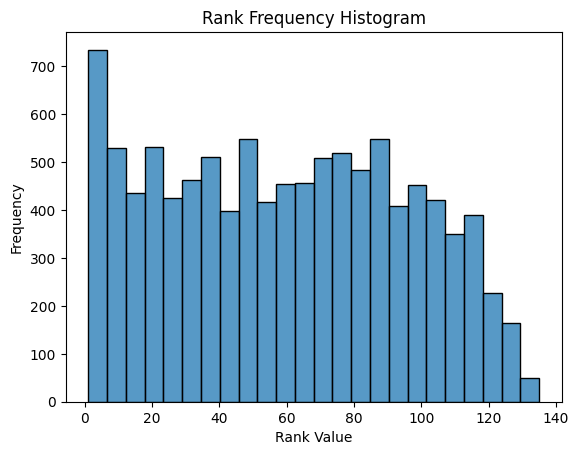

In [62]:
train_metrics = evaluate(test_triples=train_t, all_triples=all_t, model=model)

# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the histogram using seaborn
sns.histplot(train_metrics['ranks_l'] + train_metrics['ranks_r'], bins='auto', kde=False)

plt.xlabel('Rank Value')
plt.ylabel('Frequency')
plt.title('Rank Frequency Histogram')

# Display the plot
plt.show()

In [ ]:
# Let's train this model! First, let's implement a training loop

from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from livelossplot import PlotLosses

optimiser = optim.Adagrad(model.parameters(), lr=0.1)

#make sure to play with the regulariser weight to see how it affects the model
regulariser = F2()

nb_epochs = 100
batch_size = 128
regulariser_weight = 0.001

dataset = TensorDataset(train_t)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model.train()

group_patterns: Iterable[Tuple[Pattern, str]] = (
    (r'^(subject(_|-))(.*)', 'subject'),
    (r'^(object(_|-))(.*)', 'object'),
    (r'^(aggregate(_|-))(.*)', 'aggregate'),
    (r'^(train(_|-))(.*)', 'training'),
    (r'^(val(_|-))(.*)', 'validation'),
    (r'^(test(_|-))(.*)', 'test'),
)

liveloss = PlotLosses(group_patterns=group_patterns)

loss_function = nn.CrossEntropyLoss(reduction='mean')

for epoch_no in range(1, nb_epochs + 1):
    for batch_no, batch in enumerate(data_loader):
        triple_batch = batch[0]
        # Given the predicate and the object of the triple, compute a score for all possible subjects
        s_scores = model.forward(s=None, p=triple_batch[:, 1], o=triple_batch[:, 2])

        # Given the subject and the predicate of the triple, compute a scofe for all possible objects
        o_scores = model.forward(s=triple_batch[:, 0], p=triple_batch[:, 1], o=None)

        # Calculate the mismatch between the predicted scores and the gold truth -- the true subjects and objects of the triples
        s_loss = loss_function(s_scores, triple_batch[:, 0])
        o_loss = loss_function(o_scores, triple_batch[:, 2])

        factors = [model.factor(triple_batch[:, 0], is_entity=True),
                   model.factor(triple_batch[:, 1], is_entity=False),
                   model.factor(triple_batch[:, 2], is_entity=True)]

        # The loss is given by the "mismatch (loss) value" mentioned earlier, and a regularisation term
        loss = s_loss + o_loss + regulariser_weight * regulariser(factors)

        optimiser.zero_grad()

        # Compute the gradient of the training objective (L(θ) + λΩ(θ)) with respect to θ (entity and predicate embeddings)
        loss.backward()

        # Perform one stochastic gradient descent step
        optimiser.step()

    train_metrics = evaluate(test_triples=train_t, all_triples=all_t, model=model)
    valid_metrics = evaluate(test_triples=valid_t, all_triples=all_t, model=model)
    test_metrics = evaluate(test_triples=test_t, all_triples=all_t, model=model)

    logs = {'subject_loss': s_loss.item(), 'object_loss': o_loss.item(), 'aggregate_loss': loss.item(),
            'train_MRR': train_metrics['mrr'], 'val_MRR': valid_metrics['mrr'], 'test_MRR': test_metrics['mrr']}

    liveloss.update(logs)
    liveloss.send()


MRR
	training         	 (min:    0.950, max:    1.000, cur:    1.000)
	validation       	 (min:    0.864, max:    0.962, cur:    0.957)
	test             	 (min:    0.853, max:    0.965, cur:    0.958)
Loss
	subject          	 (min:    2.544, max:    3.422, cur:    2.672)
	object           	 (min:    2.249, max:    3.286, cur:    2.500)
	aggregate        	 (min:    5.103, max:    6.810, cur:    5.318)


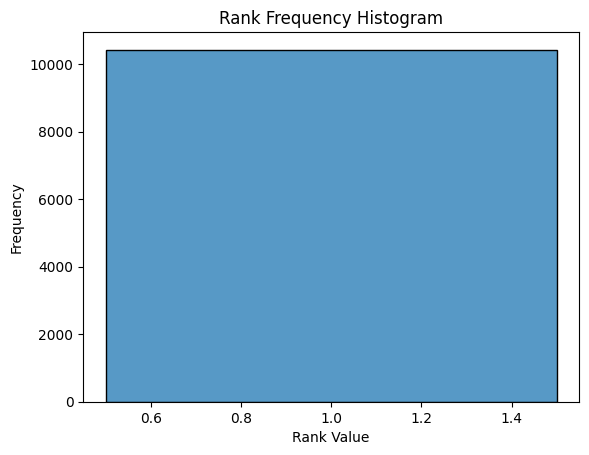

In [53]:
train_metrics = evaluate(test_triples=train_t, all_triples=all_t, model=model)
valid_metrics = evaluate(test_triples=valid_t, all_triples=all_t, model=model)
# test_metrics = evaluate(test_triples=test_t, all_triples=all_t, model=model)

sns.histplot(train_metrics['ranks_l'] + train_metrics['ranks_r'], bins='auto', kde=False)

plt.xlabel('Rank Value')
plt.ylabel('Frequency')
plt.title('Rank Frequency Histogram')

plt.show()

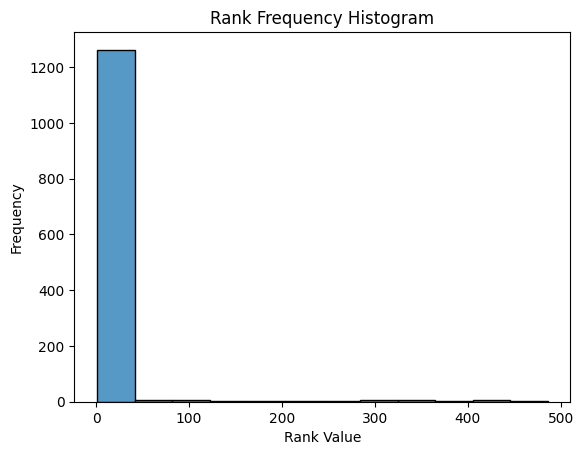

In [54]:
sns.histplot(valid_metrics['ranks_l'] + valid_metrics['ranks_r'], bins='auto', kde=False)

plt.xlabel('Rank Value')
plt.ylabel('Frequency')
plt.title('Rank Frequency Histogram')

plt.show()

# Use the implemented model to find a prediction of 2 random nodes connected by a random edge.